1. EDA for the macro/train/test
2. Feature engeering and data cleaning
4. Evaluate the model
5. Adjustment

# Start with macro
- My election base on the observation of missingness, clusting, radomforest, I filter the variables that has lowest missing value and less correlation. 
- oil_ural, gdp_quart_growth, cpi, usdrub, mortgage_value, micex, micex_cbi_tr, deposits_value
- Will test all variables with models



In [28]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

DIR_PATH = './'

Structure of macro

In [29]:
macro = pd.read_csv('macro.csv')
print macro.head(5)
print macro.shape

    timestamp  oil_urals  gdp_quart  gdp_quart_growth  cpi  ppi  gdp_deflator  \
0  2010-01-01       76.1        NaN               NaN  NaN  NaN           NaN   
1  2010-01-02       76.1        NaN               NaN  NaN  NaN           NaN   
2  2010-01-03       76.1        NaN               NaN  NaN  NaN           NaN   
3  2010-01-04       76.1        NaN               NaN  NaN  NaN           NaN   
4  2010-01-05       76.1        NaN               NaN  NaN  NaN           NaN   

   balance_trade  balance_trade_growth  usdrub         ...          \
0            NaN                   NaN     NaN         ...           
1            NaN                   NaN     NaN         ...           
2            NaN                   NaN     NaN         ...           
3            NaN                   NaN  29.905         ...           
4            NaN                   NaN  29.836         ...           

   provision_retail_space_modern_sqm  turnover_catering_per_cap  \
0                        

In [34]:
# Data structure and types
print macro.describe()
print macro.dtypes


         oil_urals     gdp_quart  gdp_quart_growth          cpi          ppi  \
count  2484.000000   2394.000000       2394.000000  2453.000000  2453.000000   
mean     86.467157  16993.230075          1.523726   407.808398   480.216347   
std      27.528709   3187.074480          2.875659    65.895969    70.286366   
min      29.112500   9995.800000         -4.500000   315.100000   337.200000   
25%      61.283300  14925.000000          0.400000   354.000000   438.400000   
50%     101.416500  17442.100000          1.300000   393.000000   473.500000   
75%     109.310000  19284.100000          4.100000   469.400000   520.700000   
max     122.520000  22016.100000          5.200000   531.000000   606.100000   

       gdp_deflator  balance_trade  balance_trade_growth       usdrub  \
count   2119.000000    2453.000000           2394.000000  2481.000000   
mean     110.122308      15.344006             16.846742    40.732406   
std       14.818429       3.878104             16.988727    

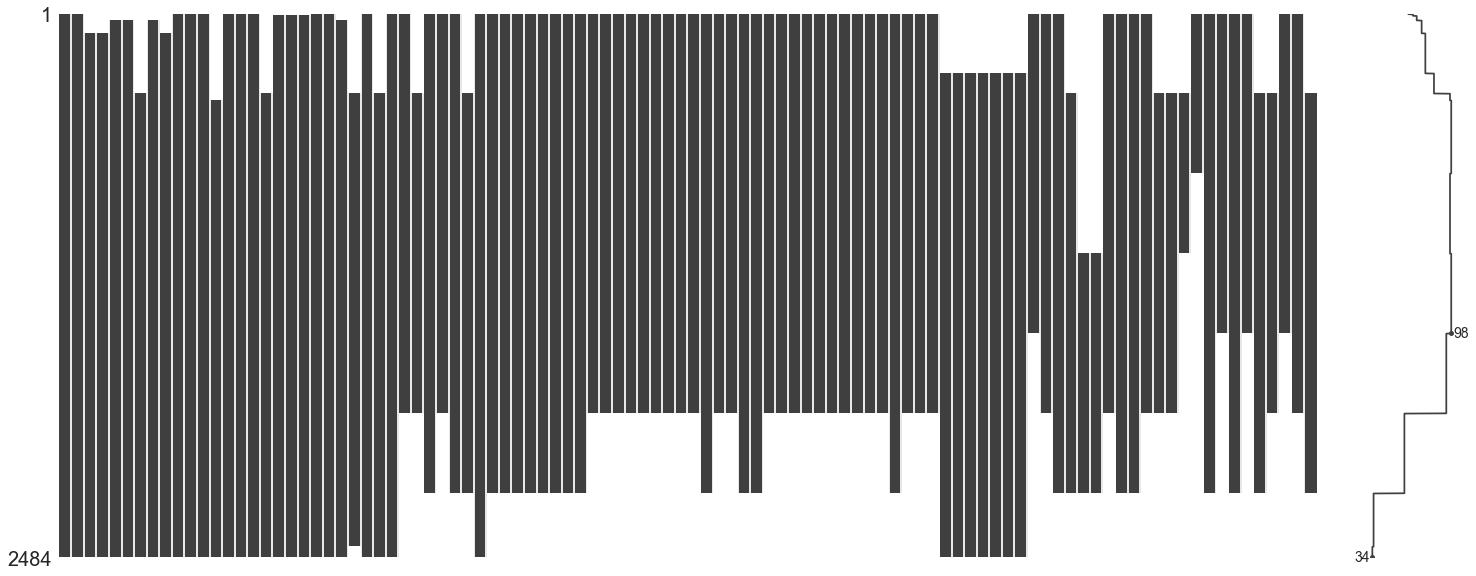

In [31]:
# Visulize the structure of missing values 
msno.matrix(macro)

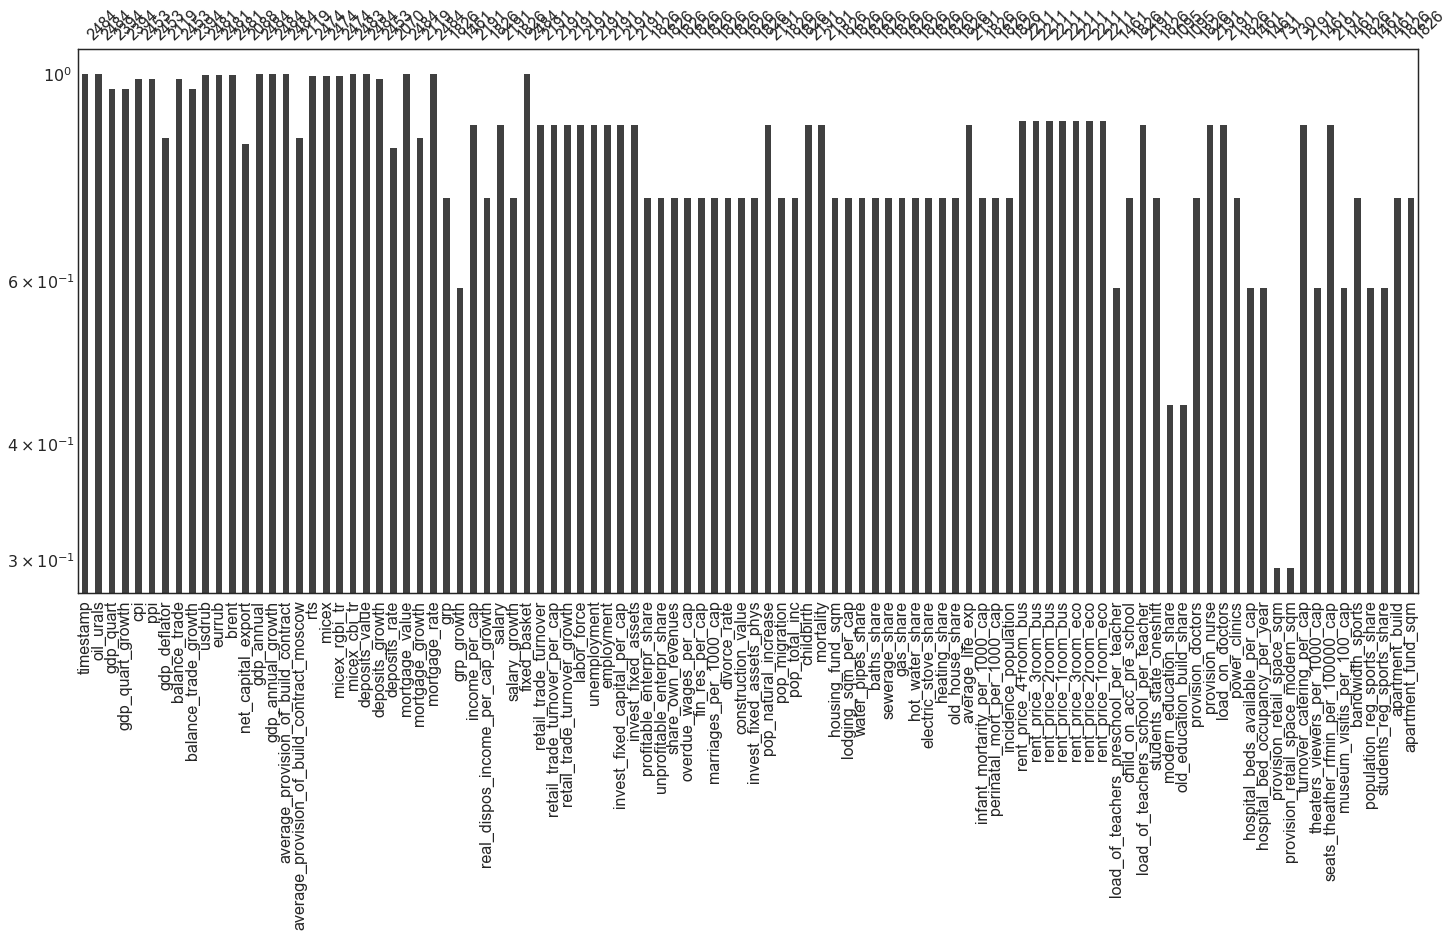

In [32]:
# Virtulize the missing value in log transformation
# There are 19 variables that has enough information with the log value close to 1.
msno.bar(macro,log=True)

In [33]:
#See the missing value numbers by each column
print np.sum(macro.isnull())

timestamp                                        0
oil_urals                                        0
gdp_quart                                       90
gdp_quart_growth                                90
cpi                                             31
ppi                                             31
gdp_deflator                                   365
balance_trade                                   31
balance_trade_growth                            90
usdrub                                           3
eurrub                                           3
brent                                            3
net_capital_export                             396
gdp_annual                                       0
gdp_annual_growth                                0
average_provision_of_build_contract              0
average_provision_of_build_contract_moscow     365
rts                                             10
micex                                           10
micex_rgbi_tr                  

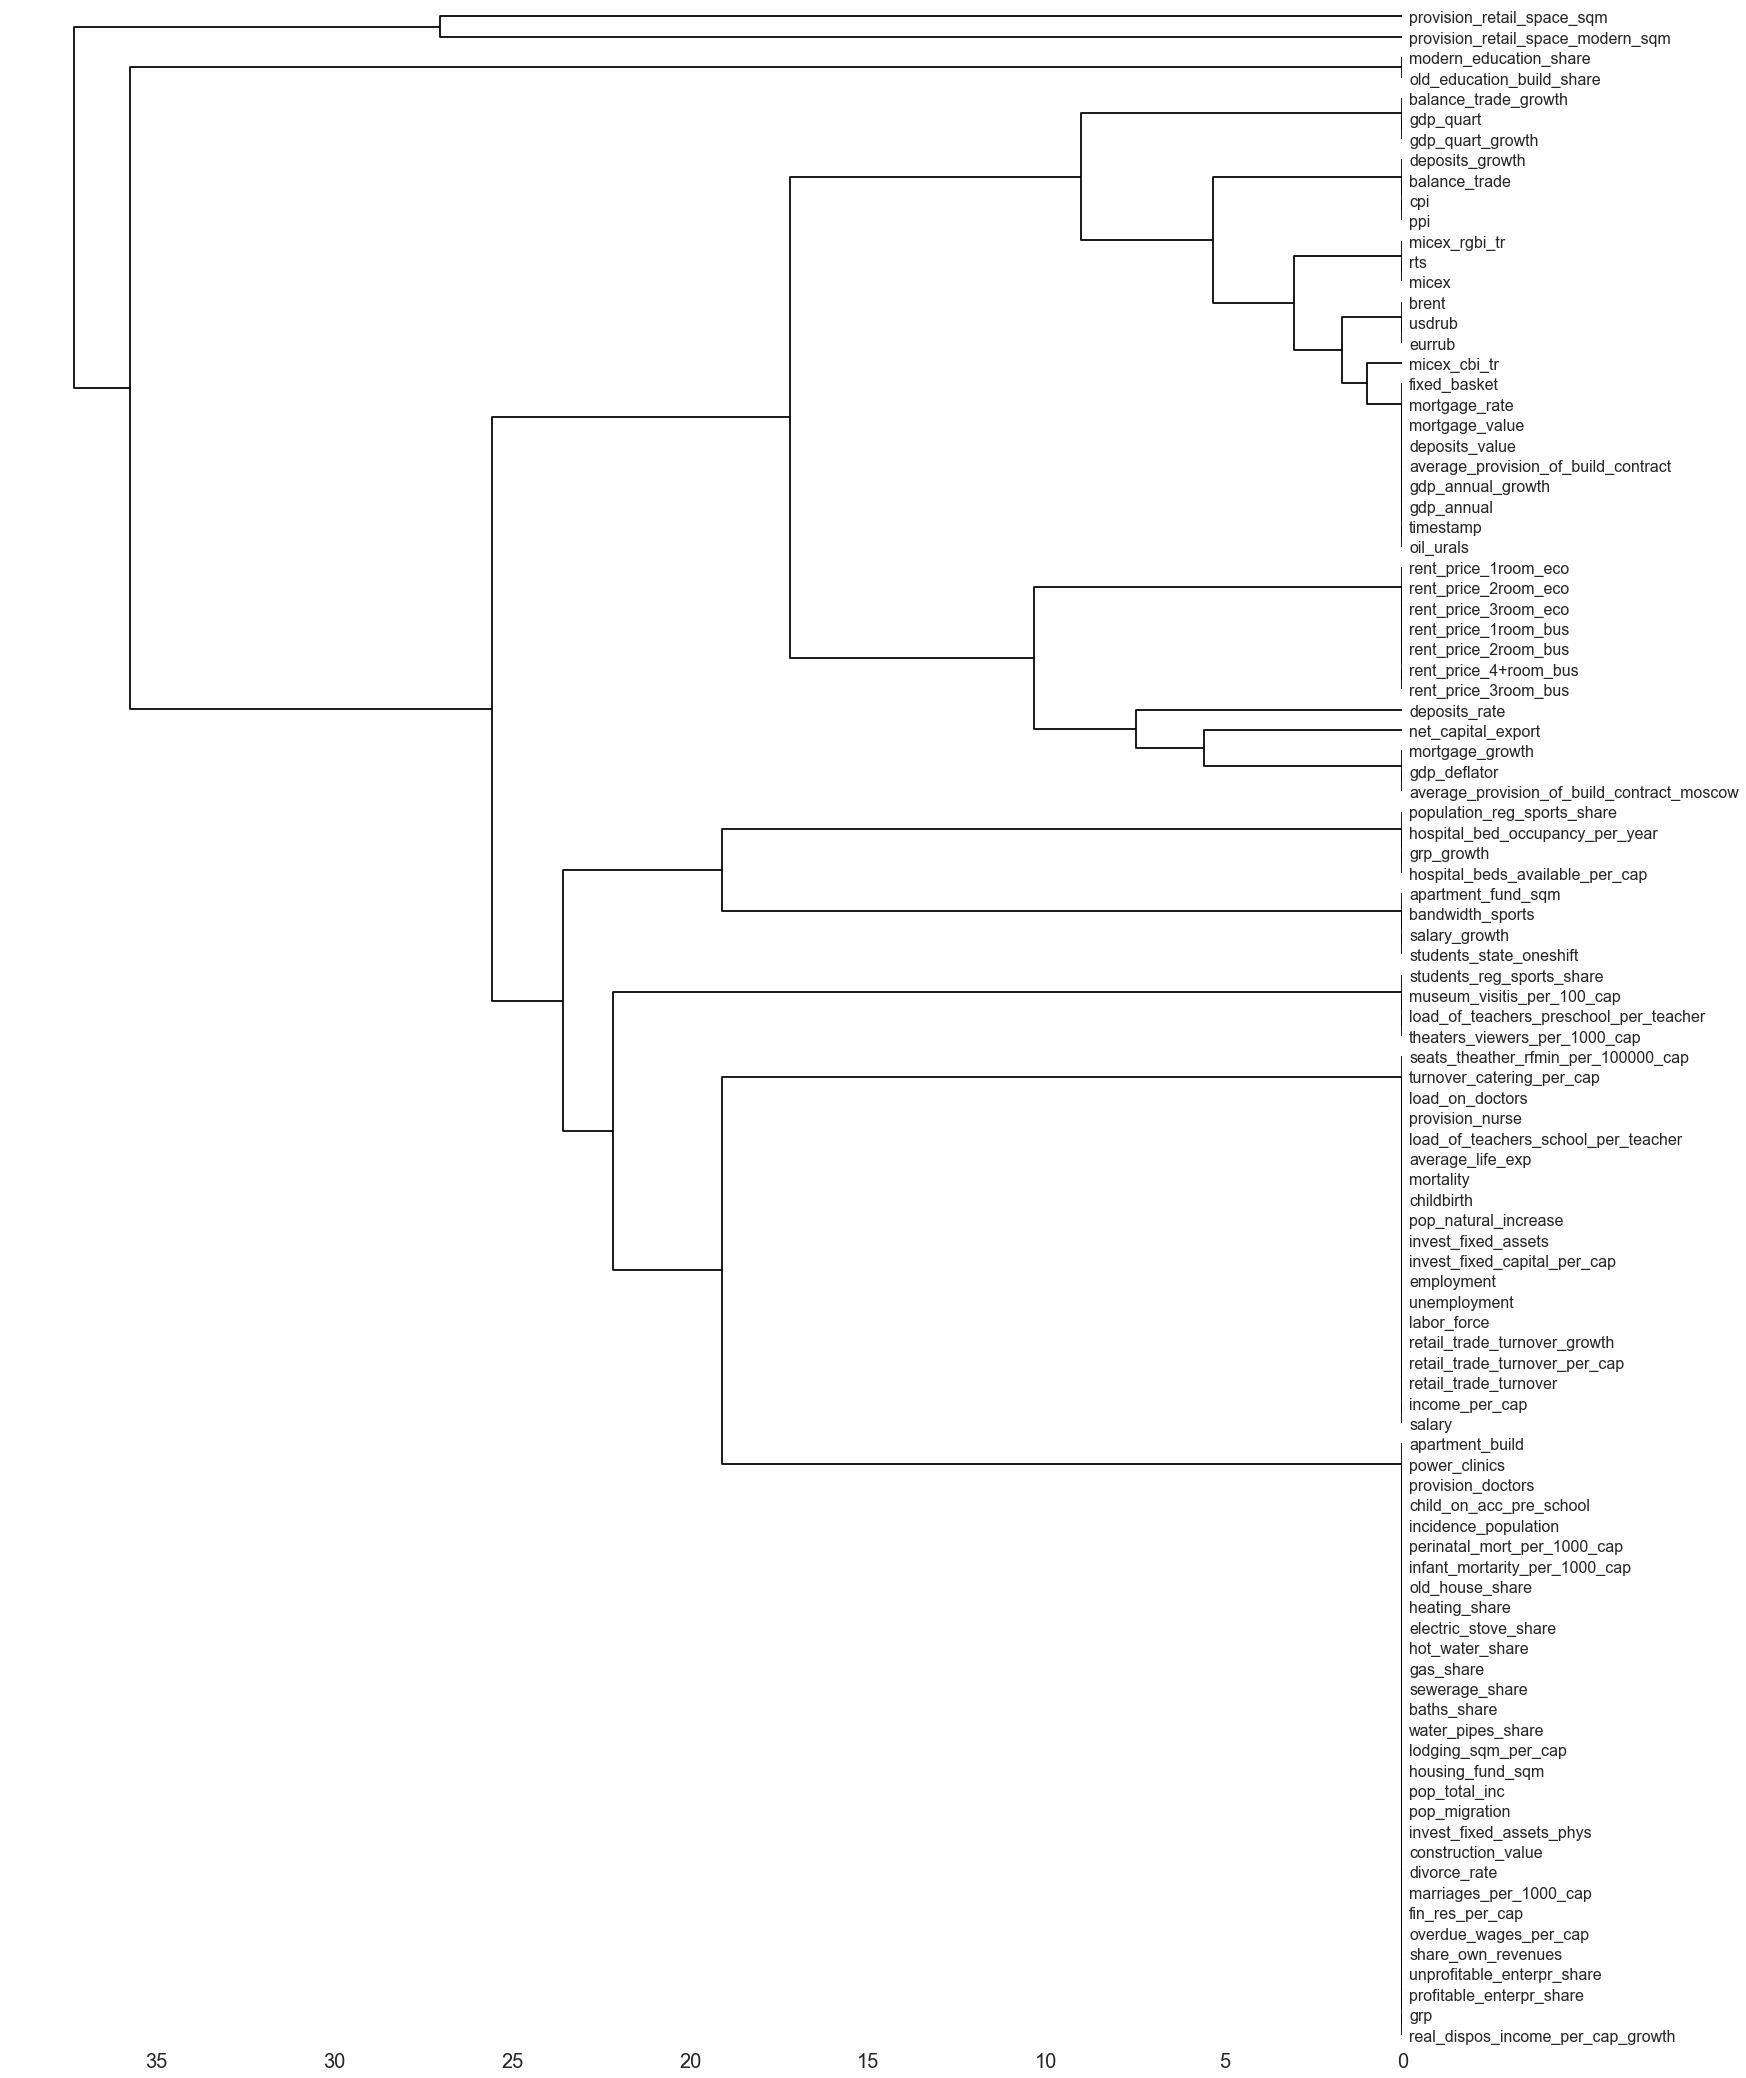

In [35]:
#The dendrogram allows you to more fully correlate variable completion, 
#revealing trends deeper than the pairwise ones visible in the correlation heatmap:
msno.dendrogram(macro)

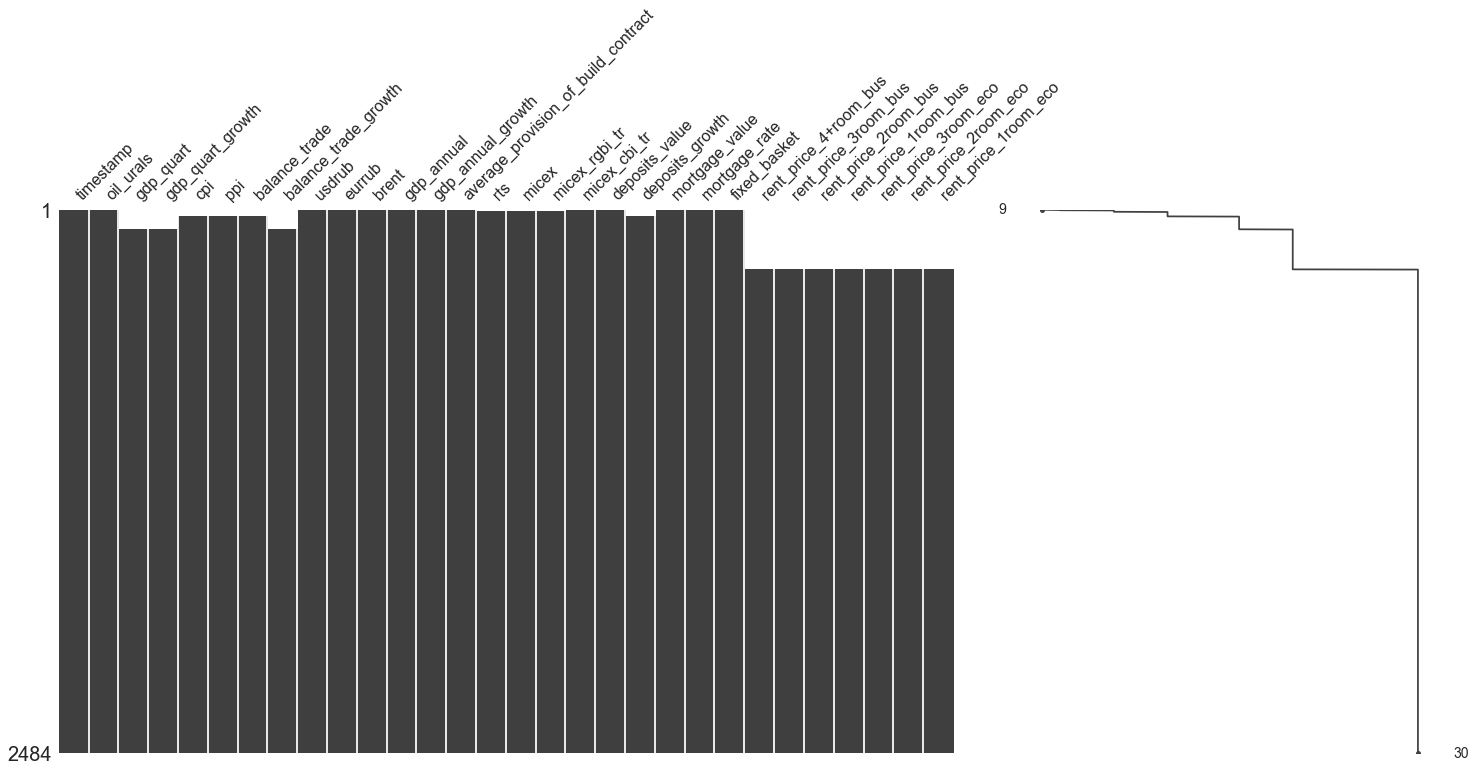

In [36]:
# Top 30 predictors with least missingness
msno.matrix(macro, filter='top', n=30, p=0, sort='ascending',width_ratios=(2, 1))

In [37]:
# Pick 10 factors and merge with 'price_doc' column in train dataset
# Find the coef of these predictors and price.
macro_select = macro[['timestamp','oil_urals', 'gdp_quart_growth', 'cpi', 'usdrub', 'mortgage_value', 'micex', 'micex_cbi_tr', 'deposits_value']]
price = train[['timestamp','price_doc']]
price_macro = pd.merge(price,macro_select,how='left', on='timestamp')

# Log-transform price_doc
price_macro['price_doc'] = np.log(price_macro.price_doc)
print price_macro.head(3)

    timestamp  price_doc  oil_urals  gdp_quart_growth    cpi   usdrub  \
0  2011-08-20  15.581952     109.31               3.3  354.0  29.0048   
1  2011-08-23  15.607270     109.31               3.3  354.0  28.9525   
2  2011-08-27  15.555977     109.31               3.3  354.0  28.8082   

   mortgage_value    micex  micex_cbi_tr  deposits_value  
0          323275  1438.74        204.78        10618898  
1          323275  1444.11        204.92        10618898  
2          323275  1458.84        204.84        10618898  


In [38]:
# See the strucute
price_macro = price_macro.drop('timestamp', axis=1)
print price_macro.head(3)
print price_macro.dtypes

   price_doc  oil_urals  gdp_quart_growth    cpi   usdrub  mortgage_value  \
0  15.581952     109.31               3.3  354.0  29.0048          323275   
1  15.607270     109.31               3.3  354.0  28.9525          323275   
2  15.555977     109.31               3.3  354.0  28.8082          323275   

     micex  micex_cbi_tr  deposits_value  
0  1438.74        204.78        10618898  
1  1444.11        204.92        10618898  
2  1458.84        204.84        10618898  
price_doc           float64
oil_urals           float64
gdp_quart_growth    float64
cpi                 float64
usdrub              float64
mortgage_value        int64
micex               float64
micex_cbi_tr        float64
deposits_value        int64
dtype: object


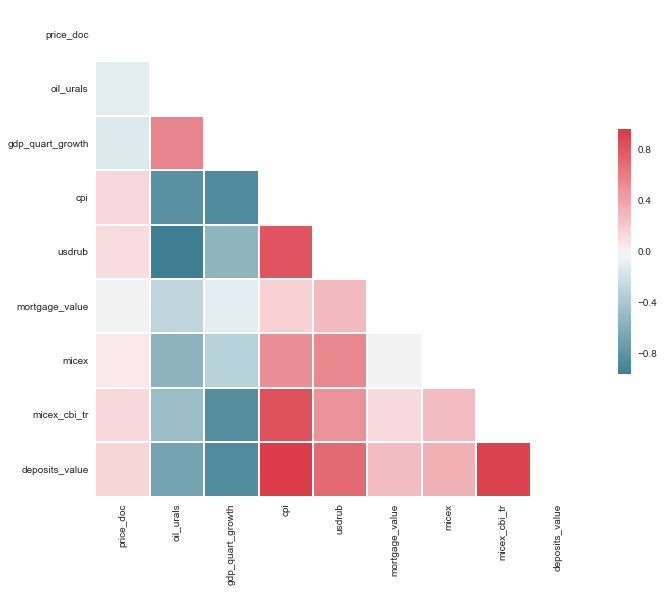

In [39]:
# Heatmap
# Morgage_value seems have close to zero coef but it has high score in randomforest test
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="white")
corr = price_macro.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.8, cbar_kws={"shrink": .5}, ax=ax)

In [40]:
print np.sum(price_macro.isnull())

price_doc           0
oil_urals           0
gdp_quart_growth    0
cpi                 0
usdrub              0
mortgage_value      0
micex               0
micex_cbi_tr        0
deposits_value      0
dtype: int64


In [3]:
price_macro = pd.read_csv('price_macro.csv')

In [42]:
# Try to filter out the low variance ones
from sklearn.feature_selection import VarianceThreshold
import sklearn.feature_selection as fs
x_new = fs.VarianceThreshold(price_macro,threshold = 1)
x_new.shape

TypeError: __init__() got multiple values for keyword argument 'threshold'

# Explore train data by the following categories (main features see jump start)
- [Demographic Features](#demographic)
- [Education Features](#school)
- [Cultural/Recreational Features](#culture)
- [Infrastructure Features](#infrastructure)
- [Variable Importance](#importance)

In [11]:
train = pd.read_csv('train.csv')
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [15]:
np.sum(train.isnull())

id                                           0
timestamp                                    0
full_sq                                      0
life_sq                                   6383
floor                                      167
max_floor                                 9572
material                                  9572
build_year                               13605
num_room                                  9572
kitch_sq                                  9572
state                                    13559
product_type                                 0
sub_area                                     0
area_m                                       0
raion_popul                                  0
green_zone_part                              0
indust_part                                  0
children_preschool                           0
preschool_quota                           6688
preschool_education_centers_raion            0
children_school                              0
school_quota 

In [43]:
train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


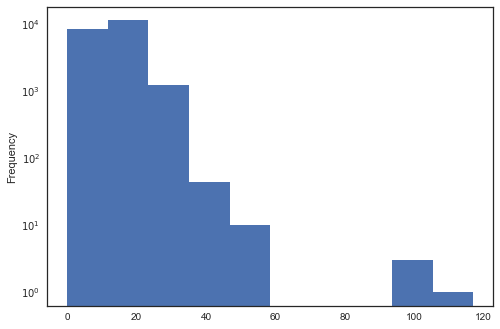

In [45]:
train.max_floor.plot.hist(log = True)

In [20]:
np.sum(train.isnull(), axis=1)

0         9
1         6
2         6
3         7
4         6
5         7
6         6
7         6
8         6
9         6
10        7
11       12
12        6
13        6
14        6
15        7
16       10
17        7
18        7
19        6
20       18
21        7
22        6
23        7
24        7
25       10
26        7
27        6
28       10
29        6
         ..
30441     0
30442    25
30443     5
30444     2
30445     0
30446    31
30447     6
30448     9
30449     0
30450     4
30451    39
30452     0
30453     4
30454     1
30455    21
30456     1
30457     3
30458     6
30459     5
30460     0
30461     0
30462     0
30463     0
30464     3
30465     2
30466     1
30467     0
30468    21
30469     0
30470     0
dtype: int64

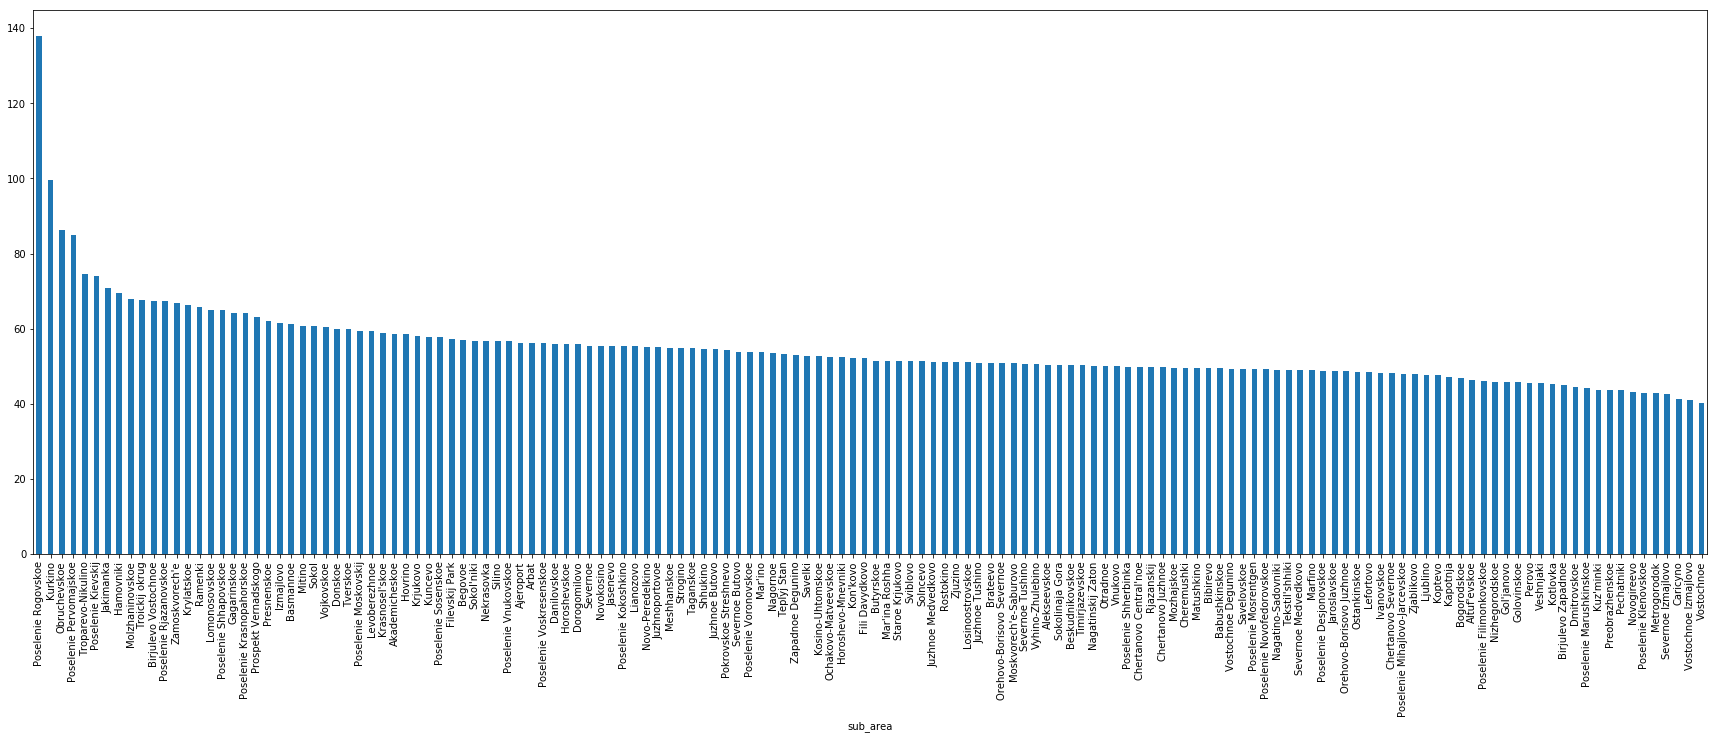

In [50]:
# See the which area has the most avg full_sq 
plt.figure(figsize=(30,10))
train.groupby('sub_area')['full_sq'].mean().sort_values(ascending=False).plot.bar()

In [46]:
#test
#sns.lmplot("mortgage_growth", "cpi", macro)
#sns.lmplot("mortgage_value", "cpi", macro)

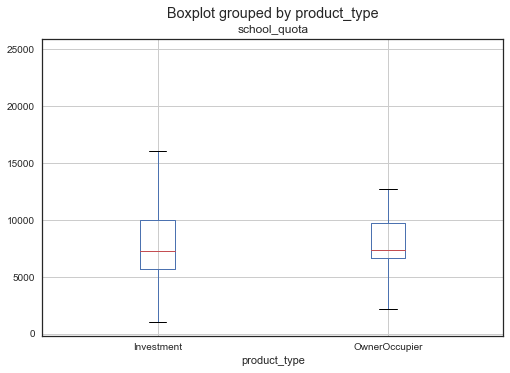

In [48]:
train.boxplot(by='product_type', column='school_quota')
# Investment property has larger range than ownerOccupier when school quota take in to consideration

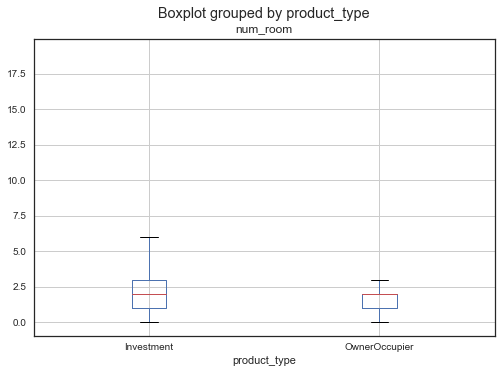

In [49]:
train.boxplot(by='product_type', column='num_room')

In [2]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()

In [ ]:
ax = sns.heatmap(price_macro_sub)

# Bo recommended to use this simple liner regression first to filter out the predictors that has close to zero coef.

In [ ]:
linear = LinearRegression()
linear.fit(train_everything,price_doc)
print(linear.coef_ < 1e-3)

np.sum(linear.coef_ < 1e-4) # how many column do we erase
index = ...
newx = x[index] # only a half of columns to use

#testingerror
np.sum((price_doc - linear.predict(newx))**2


then go to better model...
       


